In [2]:
# from sentence_transformers import SentenceTransformer
from datasets import load_dataset, load_from_disk, Dataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
import itertools
from collections import Counter
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score

In [2]:
docs = [
    'I bought the Apple phone',
    'I bought an apple from the supermart',
    'The apple tastes nice'
]

# Loading Models

In [3]:
# ！The default dimension is 1024, if you need other dimensions, please clone the model and modify `modules.json` to replace `2_Dense_1024` with another dimension, e.g. `2_Dense_256` or `2_Dense_8192` !
# on gpu
# stella = SentenceTransformer("dunzhang/stella_en_400M_v5", trust_remote_code=True).cuda()
# you can also use this model without the features of `use_memory_efficient_attention` and `unpad_inputs`. It can be worked in CPU.
stella = SentenceTransformer(
    "dunzhang/stella_en_400M_v5",
    trust_remote_code=True,
    config_kwargs={"use_memory_efficient_attention": False, "unpad_inputs": False}
).cuda()
# query_embeddings = stella.encode(queries, prompt_name=query_prompt_name)
doc_embeddings = stella.encode(docs)
print(doc_embeddings.shape)

similarities = stella.similarity(doc_embeddings, doc_embeddings)
print(similarities)

modeling.py:   0%|          | 0.00/57.5k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/dunzhang/stella_en_400M_v5:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Some weights of the model checkpoint at dunzhang/stella_en_400M_v5 were not used when initializing NewModel: ['new.pooler.dense.bias', 'new.pooler.dense.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(3, 1024)
tensor([[1.0000, 0.8168, 0.6808],
        [0.8168, 1.0000, 0.7002],
        [0.6808, 0.7002, 1.0000]])


/workspace/kernels/transformers-stable/lib/python3.11/site-packages/transformers/modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [4]:
gte = SentenceTransformer('Alibaba-NLP/gte-large-en-v1.5', trust_remote_code=True)
embeddings = gte.encode(docs)
print(cos_sim(embeddings[2], embeddings[1]))

tensor([[0.6859]])


# Loading Data

In [3]:
ds = load_dataset("mteb/stackexchange-clustering")["test"]
ds

Dataset({
    features: ['sentences', 'labels'],
    num_rows: 25
})

In [4]:
# Create flattened dataset
sentences = list(itertools.chain.from_iterable(ds["sentences"]))
labels_raw = itertools.chain.from_iterable(ds["labels"])
labels = list(map(lambda x: x.split(".")[0], labels_raw))

flattened_ds = Dataset.from_dict({"label": labels, "sentence": sentences})
flattened_ds

Dataset({
    features: ['label', 'sentence'],
    num_rows: 373850
})

In [11]:
# Sample data
flattened_ds[355550:355555]

{'label': ['ux', 'ux', 'ux', 'ux', 'ux'],
 'sentence': ['What is a good way to auto-generate an attribute value?',
  'Should an interaction designer know how to do visual design',
  'What is a name for this "plate" scrolling functionality?',
  'How do approaches for UX differ between intranets and normal websites?',
  'What are the minimal guidelines for a dual command-line / gui interface?']}

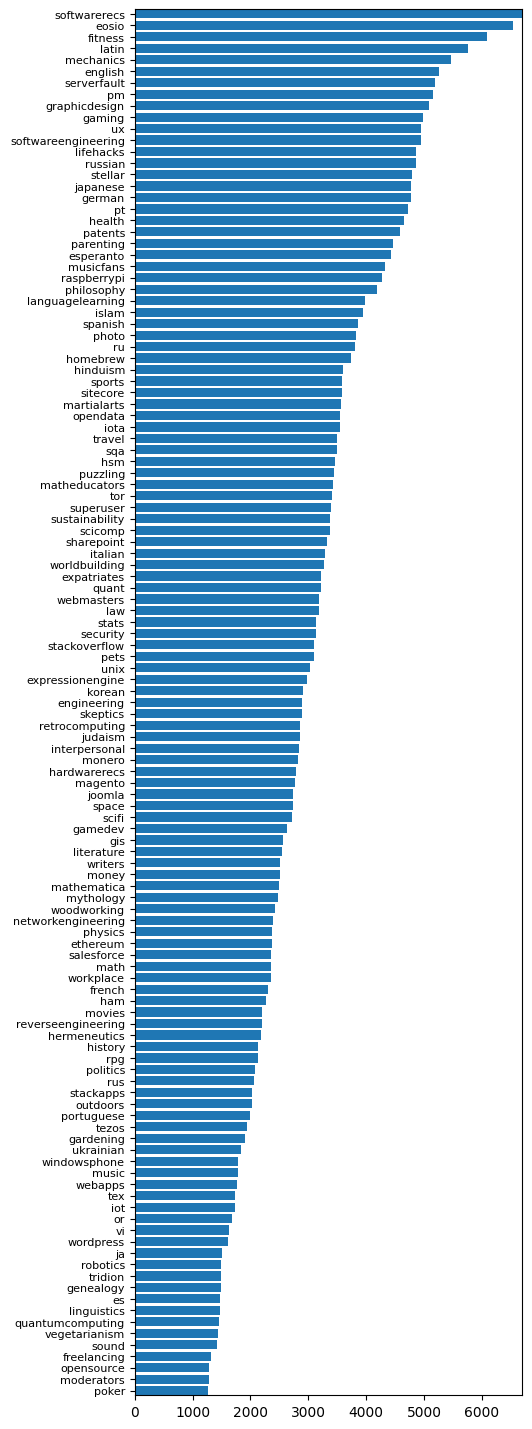

In [6]:
# Check label distribution
label_distribution = Counter(labels)
sorted_label_distribution = sorted(label_distribution.items(), key=lambda x: x[1])
labels_unique, labels_count = zip(*sorted_label_distribution)

fig, ax = plt.subplots(figsize=(5,18))
ax.barh(labels_unique, labels_count, height=0.8)
plt.yticks(fontsize=8)
plt.margins(0)

In [24]:
# Choose only largest K classes for testing
K = 4
top_labels, top_counts = zip(*sorted_label_distribution[-K:])
print(top_labels, sum(top_counts), top_counts)
top_ds = flattened_ds.filter(lambda x: x['label'] in top_labels)
top_ds = top_ds.class_encode_column("label")

# Perform stratified subsampling
desired_size = 20000
sampled_ds = top_ds.train_test_split(train_size=desired_size/len(top_ds), stratify_by_column='label')['train']

('latin', 'fitness', 'eosio', 'softwarerecs') 25071 (5764, 6080, 6533, 6694)


Filter:   0%|          | 0/373850 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/25071 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/25071 [00:00<?, ? examples/s]

# Generating Embeddings

In [25]:
def embed_docs(examples):
    embeddings_gte = gte.encode(examples['sentence'])
    embeddings_stella = stella.encode(examples['sentence'])
    return {"gte": embeddings_gte, "stella": embeddings_stella}

sampled_ds_embed = sampled_ds.map(embed_docs, batched=True, batch_size=32)

/workspace/kernels/transformers-stable/lib/python3.11/site-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class 'transformers_modules.Alibaba-NLP.new-impl.40ced75c3017eb27626c9d4ea981bde21a2662f4.modeling.NewAttention'>.
  StockPickler.save(self, obj, save_persistent_id)
/workspace/kernels/transformers-stable/lib/python3.11/site-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class 'transformers_modules.Alibaba-NLP.new-impl.40ced75c3017eb27626c9d4ea981bde21a2662f4.modeling.NewAttention'>: transformers_modules.Alibaba-NLP.new-impl.40ced75c3017eb27626c9d4ea981bde21a2662f4.modeling.NewAttention has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

/workspace/kernels/transformers-stable/lib/python3.11/site-packages/transformers/modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Since we are dealing with 1024 dimensions), if we want to visualise and get a rough estimate on the goodness of our clusters, we need to find a way to represent these vectors in just 2 dimensions. For that reason, we generate TSNE coordinates using normalized cosine distance (ie. 1 - cosine similarity) as the distance metric.

In [26]:
tsne = TSNE(random_state=1, max_iter=1000, metric="cosine")
sampled_ds_tsne = sampled_ds_embed.add_column("tsne_gte", list(tsne.fit_transform(normalize(sampled_ds_embed['gte']))))
sampled_ds_tsne = sampled_ds_tsne.add_column("tsne_stella", list(tsne.fit_transform(normalize(sampled_ds_embed['stella']))))

sampled_ds_tsne

Dataset({
    features: ['label', 'sentence', 'gte', 'stella', 'tsne_gte', 'tsne_stella'],
    num_rows: 20000
})

In [27]:
sampled_ds_tsne.save_to_disk("dataset-stackoverflow.hf")

Saving the dataset (0/1 shards):   0%|          | 0/20000 [00:00<?, ? examples/s]

# Visualising

In [12]:
sampled_ds = load_from_disk("dataset-stackoverflow.hf")
sampled_ds

Dataset({
    features: ['label', 'sentence', 'gte', 'stella', 'tsne_gte', 'tsne_stella'],
    num_rows: 20000
})

## TSNE

In [15]:
np_ds = sampled_ds.with_format("numpy")

In [16]:
colors = ['r', 'g', 'b', 'y']
class_names = sampled_ds.features['label'].names
index_to_colour_names = {i:(color, name) for i, (color, name) in enumerate(zip(colors, class_names))}
index_to_colour_names

{0: ('r', 'eosio'),
 1: ('g', 'fitness'),
 2: ('b', 'latin'),
 3: ('y', 'softwarerecs')}

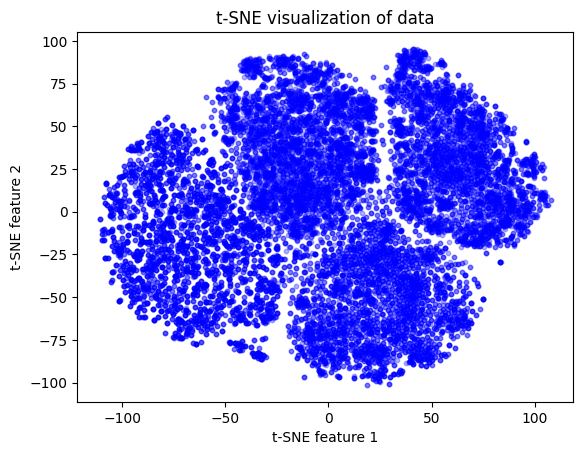

In [18]:
# Stella

for i, (color, name) in index_to_colour_names.items():
    indices = np_ds['label'] == i
    scatter = plt.scatter(np_ds['tsne_stella'][indices, 0], np_ds['tsne_stella'][indices, 1], 
                          c='b', 
                          s=10,  # Reduced dot size
                          alpha=0.3,  # Add transparency
                          label=name)

plt.title('t-SNE visualization of data')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')

# Add a text legend
# plt.legend()

plt.show()

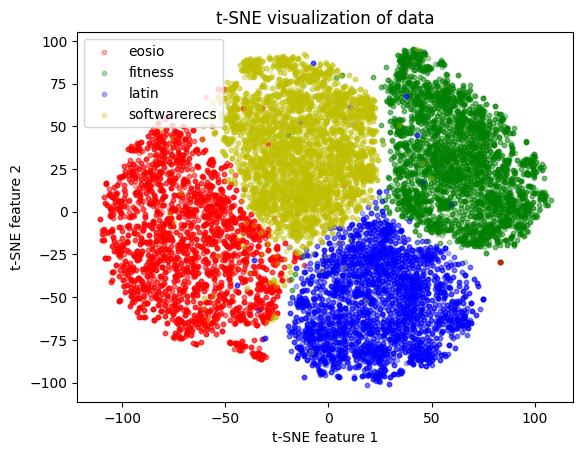

In [43]:
# Stella

for i, (color, name) in index_to_colour_names.items():
    indices = np_ds['label'] == i
    scatter = plt.scatter(np_ds['tsne_stella'][indices, 0], np_ds['tsne_stella'][indices, 1], 
                          c=color, 
                          s=10,  # Reduced dot size
                          alpha=0.3,  # Add transparency
                          label=name)

plt.title('t-SNE visualization of data')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')

# Add a text legend
plt.legend()

plt.show()

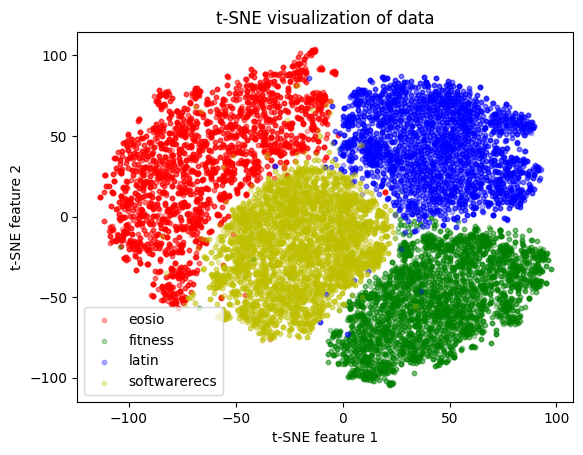

In [44]:
# GTE

for i, (color, name) in index_to_colour_names.items():
    indices = np_ds['label'] == i
    scatter = plt.scatter(np_ds['tsne_gte'][indices, 0], np_ds['tsne_gte'][indices, 1], 
                          c=color, 
                          s=10,  # Reduced dot size
                          alpha=0.3,  # Add transparency
                          label=name)

plt.title('t-SNE visualization of data')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')

# Add a text legend
plt.legend()

plt.show()

Both stella and GTE gives rather good embeddings that well-distinguish clusters from one another, with clusters having a "gap" of much lower density of datapoints in between them.

From now onwards, we will exclusively base our discussion on the Stella embeddings

# Evaluating Cluster Goodness

In [61]:
X_normalized = normalize(np_ds["stella"])

## Silhouette Score

0.16752353


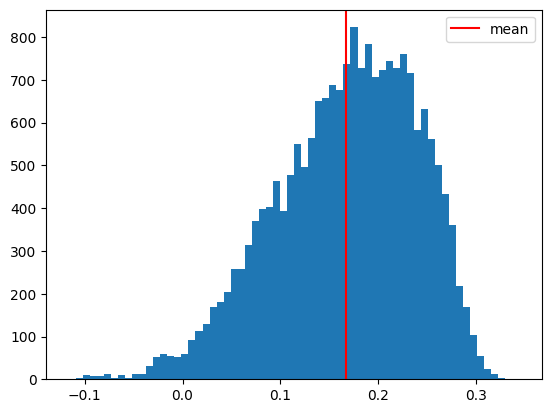

In [74]:
silhouette_all = silhouette_samples(X_normalized, np_ds["label"], metric='cosine')
silhouette_avg = silhouette_all.mean()
print(silhouette_avg)

plt.hist(silhouette_all, bins=64)
plt.axvline(silhouette_avg, color = 'r', label='mean')
plt.legend()
plt.show()

In [131]:
# Qualitative checking of datapoints with negative sillhouette scores 
bad_samples_idx = silhouette_all < -0.05
print(
    list(zip(
        list(np_ds["sentence"][bad_samples_idx].tolist()),
        map(lambda x: np_ds.features['label'].names[x], np_ds["label"][bad_samples_idx].tolist())
    ))
)

[('Meaning of "time in zone"', 'fitness'), ('Tool for tracking BPs performance', 'eosio'), ('How to avoid excessive concentration?', 'eosio'), ('Tool for tracking BPs performance', 'eosio'), ('Absit Invidia as a command', 'latin'), ('Tool for tracking BPs performance', 'eosio'), ('Brain trainer —\xa0exercise perception, cognition and memory', 'softwarerecs'), ('Meaning of "time in zone"', 'fitness'), ('Absit Invidia as a command', 'latin')]


We note that the average silhouette score seems slightly lower than expected:
- Despite the clusters clearly distinguishable, the mean sillhouette score is very close to 0
- A datapoint having a sillhouette score of 0 means that it is on average as close to each other point in its same cluster, as it is to each other point in the most neighbourin cluster
    - Intuitively, this means that it is valid for the datapoint to be assigned to either cluster
- Upon closer inspection, we see that the scores are mostly distributed between 0 and 0.3, with very few datapoints (~1.67%) having a negative score
    - This indicates that while the clusters themselves are not very tight, almost all data points are naturally situated such that the cluster that they belong to can be distinguished relatively easily.

## Davies-Bouldin Index

In [132]:
davies_bouldin_avg = davies_bouldin_score(X_normalized, np_ds["label"])
print(davies_bouldin_avg)

3.0734580996799794


While it is not standard practice to compare embeddings using Euclidean distance, in this instance, we have already normalized the embeddings to have a magnitude of 1, thus the Davies-Bouldin Index can serve as a baseline for comparison when we are experimenting with different classification techniques